## 静态文件
- 新建static文件夹
- STATIC_URL = '/static/' 设置静态文件url地址
- STATICFILES_DIRS = [os.path.join(BASE_DIR, 'static')]
- 加载目录：STATICFILES_FINDERS = (...)，首先查找settings中的文件夹；之后加载app目录下的static文件夹

---

##### 动态获取静态文件夹路径
- {% load staticfiles %}
- src = "{% static 'images/mm.jpg' %}" 拼接路径
- {% static ... %}获取到静态文件夹路径

## 中间件
- 中间件：django预留的函数接口，用来干预请求和应答过程
- request.META['REMOTE_ADDR'] 获取浏览器端ip地址
- **创建中间件文件-->创建中间件类-->创建中间件函数-->注册中间件类**
- 1、app文件夹中创建middleware.py--->views.py调用前调用

```python
class AnyNameMiddleware(object):
    '''中间件类'''
    def __init__(self):
        pass
    
    # 中间件函数，函数名及参数固定
    def process_request(self, request):
        pass
    
    def process_view(self, request, view_func, *view_args, **view_kwargs):
        pass
    
    def process_response(self, request, response):
        pass
    
    def process_exception(self，request, exception):
        pass

```
- 2、settings.py中MIDDLEWARE_CLASSES里注册中间件类

---
##### 中间件函数调用顺序
- `__init__`:服务器重启后，接收第一个请求时
- process_request：产生request对象后，匹配urls之前
- process_view：匹配urls之后，调用views函数之前
- process_response：调用views函数之后，返回response之前
- process_exception：执行views函数产生异常时，多个中间件函数调用顺序与注册顺序相反
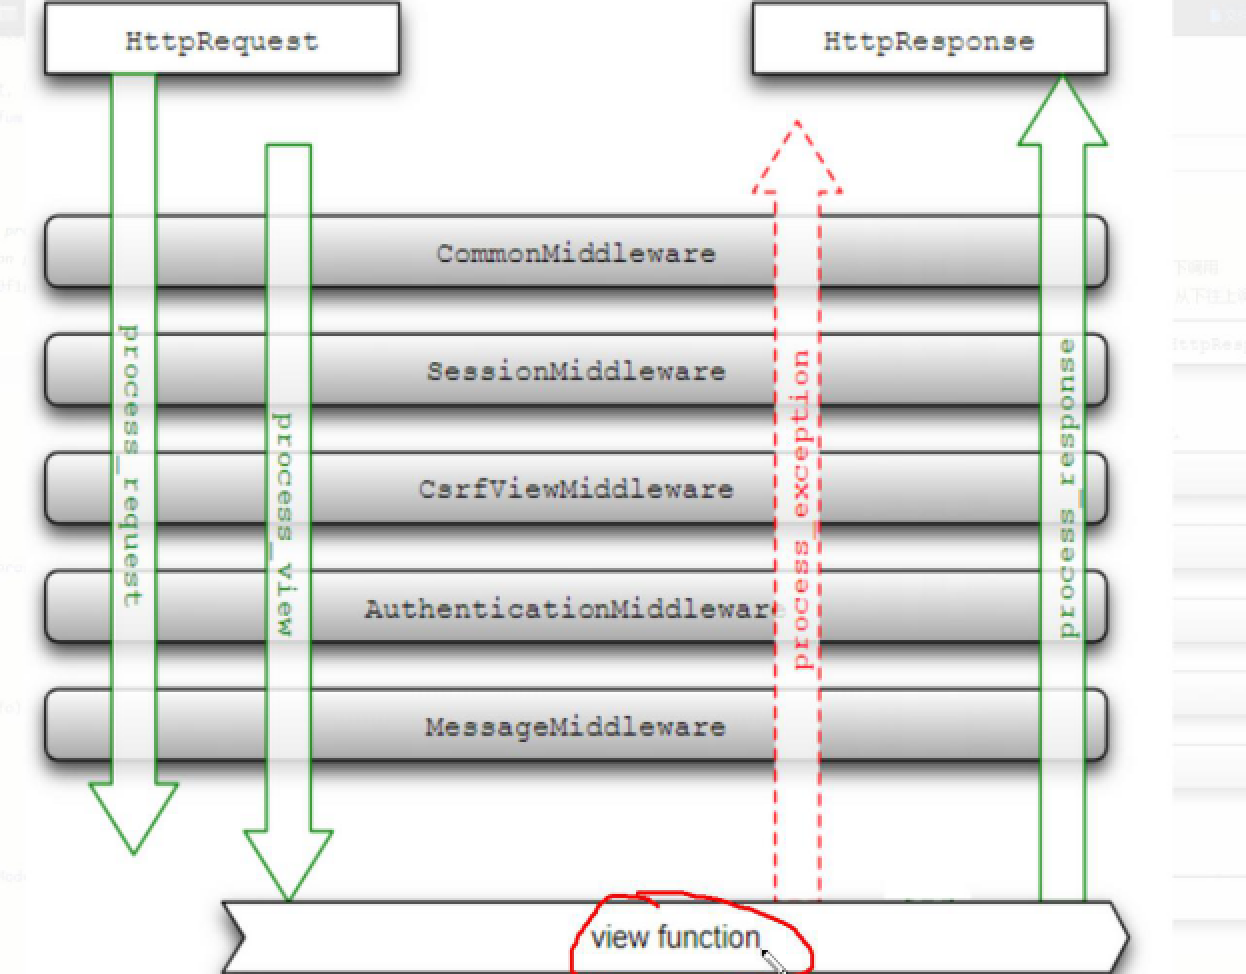

## Admin后台管理
- 本地化，语言和时区
- 创建超级管理员
- admin.py注册模型类
- 自定义管理页面

```python
# models.py

class AreaInfo(model.models):
    atitle = models.CharField(max_length=20, verbose_name = '地区') # verbose_name = '地区'，栏的名字显示中文
    aParent = models.ForeignKey('self', null=True, blank=True)
    def __str__(self):
        return self.atitle
    def title(self):
        return self.atitle
    title.admin_order_field = "atitle" # 使自定义方法可排序
    title.short_description = "地区名称" # 使自定义方法显示的栏的名字显示中文
    
    class Meta:
        verbose_name = "省市县"
        verbose_name_plural = "省市县表"
```

```python

# admin.py

class AreaStackedInline(admin.StackedInline):
    model = AreaInfo
    extra = 2
    
class AreaTabularInline(admin.TabularInline):
    model = AreaInfo
    extra = 2
    
class AreaInfoAdmin(admin.Model):
    list_per_page = 10 # 每页显示几个
    list_display = ['id','title'] # 可以添加模型类属性和方法
    action_on_bottom = True # 底部显示动作
    action_on_top = False # 顶部显示动作
    list_filter = ['atitle'] # 右侧显示过滤栏
    search_fields = ['atitle'] # 上方添加搜索栏
    
    # fields = ['aParent','atitle'] # 设置详情页显示顺序
    fieldsets = (
        ('基本'，{"fields":["atitle"]})
        ('高级'，{"fields":["aParent"]})
    ) # 详情页分类
    
    # inlines = [AreaStackedInline] # 分类显示关联字段
    inlines = [AreaTabularInline] # 表格显示分类字段
    
admin.site.register(AreaInfo, AreaInfoAdmin)
```

## 上传图片
- 配置上传文件保存目录，新建目录media(名字随意)
- setting设置：MEDIA_ROOT = os.path.join(BASE_DIR, 'static/media')
##### 后台管理上传
- 新建模型类，设置字段类型FileField或ImageField
- 例如ImageField(upload_to='MEDIA_ROOT的相对目录')
- admin.py注册模型类
##### 自定义页面上传
- 前端表单类型method="post" enctype = "multipart/form_data"
- 添加input标签，file类型
- 上传文件不大于2.5mb，保存在数据库
- 上传文件大于2.5mb，单独保存

```python
def upload_handle(request):
    '''上传图片处理'''
    # 1.获取上传文件的处理对象
    pic = request.FILES['pic']

    # 2.创建一个文件
    save_path = '%s/booktest/%s'%(settings.MEDIA_ROOT,pic.name)
    with open(save_path, 'wb') as f:
        # 3.获取上传文件的内容并写到创建的文件中
        for content in pic.chunks():
            f.write(content)

    # 4.在数据库中保存上传记录
    PicTest.objects.create(goods_pic='booktest/%s'%pic.name)

    # 5.返回
    return HttpResponse('ok')
```

## 分页
- 数据库查询 areas = AreaInfo.object.filter(aParent__isnull=True)
- {% for area in areas %}...{% endfor %}
- 导入模块 from django.core.paginator import Paginator
- 创建分页对象 paginator = Paginator(areas, 10)
- 获取第一页 page = paginator.page(1) 
- {% for area in page.object_list %}...{% endfor %} 遍历第一页中的查询集，page也是可遍历的
##### paginator属性
- num_pages：返回总页数
- page_range：返回页码列表
##### paginator属性
- page(num)：返回第num页的page（起始数字为1）
##### page属性
- number：返回当前页码
- paginator：返回对应的Paginator对象
##### page方法
- has_previous：是否有上一页
- has_next：是否有下一页
- previous_page_number：返回上一页页码
- next_page_number：返回下一页页码